## __GPM자료를 이용해서 딥러닝하기 1__

### __MLP구현하기__

2022.04.30 @Yeji Choi

In [2]:
import numpy as np
import glob

In [3]:
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path='/content/drive/MyDrive/Colab Notebooks/dacon/'
file_list=sorted(glob.glob(path+'*.npy'))

In [5]:
len(file_list)

41

In [6]:
x_data=[]
y_class=[]
y_reg=[]
for fi in file_list[:39]:
    data=np.load(fi)
    x_data.append(data[:,:10])
    y=np.where(data[:,14]==0,0,1)
    y_class.append(y)
    y_reg.append(data[:,14])  

In [7]:
x_data=np.array(x_data)
y_class=np.array(y_class)
y_reg=np.array(y_reg)
x_data.shape, y_class.shape, y_reg.shape

((39, 1600, 10), (39, 1600), (39, 1600))

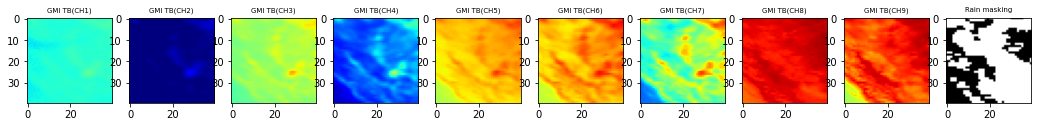

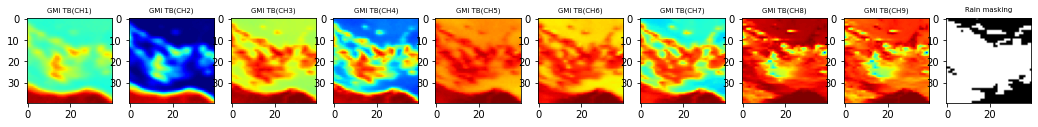

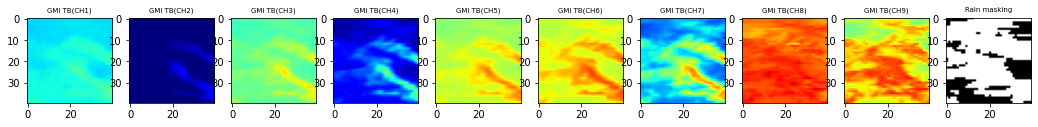

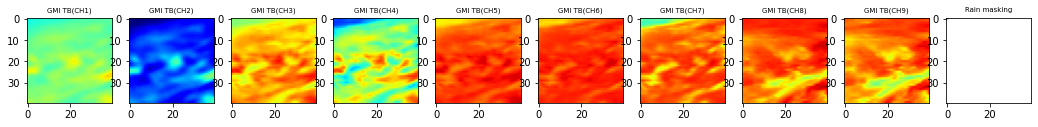

In [8]:
import matplotlib.pyplot as plt

idx=[0,10,20,30]
for i in idx:
    fig = plt.figure(figsize=(18,2))
    rows = 1
    cols = 10
    for j in range(10):
        ax1 = fig.add_subplot(rows, cols, j+1)
        if j <= 8:
            x_da = x_data.reshape(-1,40,40,10)
            ax1.imshow(x_da[i,:,:,j], cmap='jet', vmin=100, vmax=280)
            ax1.set_title('GMI TB(CH'+str(j+1)+')', size='x-small')
        else:
            y_cl = y_class.reshape(-1,40,40)
            ax1.imshow(y_cl[i,:,:], cmap='gist_gray', vmin=0, vmax=1)
            ax1.set_title('Rain masking', size='x-small')
        ax1.axis("on")
    plt.show()

#  Forward propagation: XOR 문제 해결하기

<img src="http://drive.google.com/uc?export=view&id=1SyY6F6-P2WZ7Hna6RQu7tnaQfgCsF_Ry" width="480px" height="480px" >

### multi-layer Perceptron 으로 XOR 문제 해결하기

## Pytorch

__torch.matmul__  
vector 및 matrix 간의 다양한 곱을 수행한다.   
broadcast 기능을 제공하며 가장 일반적으로 사용되나, broadcast 기능이 도리어 debug point가 될 수 있다.   
  
__torch.mm__
torch.matmul과 차이점은 broadcast가 안 된다는 점이다.  
즉 mm은 정확하게 matrix 곱의 사이즈가 맞아야 사용이 가능하다.  



## torch.nn 모듈 사용해서 XOR 문제 해결하기

모든 neural network 관련된 패키지는 `torch.nn` 모듈안에 다 있다. 

Deep Neural Network를 만든다는 것은 아래 그림 처럼 층을 하나하나씩 쌓는 것과 같다.

<img src="http://drive.google.com/uc?export=view&id=1tSHTZLkpV4Qak7KjO0DafB1RsqL7xyDq" width="180px" height="240px" >

학습할 매개변수는 구분하여 층을 만들고 그렇지 않은 층(활성화함수)는 하나로 정의하여 재 사용하면 된다.

PyTorch Document: 

* [torch.nn.Linear](https://pytorch.org/docs/stable/nn.html#linear)
* [torch.nn.Sigmoid](https://pytorch.org/docs/stable/nn.html#sigmoid)


In [11]:
import torch

In [12]:
import torch.nn as nn
device = torch.device("cuda")

In [13]:
torch.manual_seed(70)

# 선형결합, sigmoid 모듈 선언
linear1 = nn.Linear(in_features=2, out_features=3)   
linear2 = nn.Linear(in_features=3, out_features=2)
linear3 = nn.Linear(in_features=2, out_features=2)
activation_layer = nn.Sigmoid()
identity_layer = nn.Identity()

# 입력데이터
x = torch.Tensor([[0, 1]])

# forward 과정
z1 = linear1(x)
a1 = activation_layer(z1)
z2 = linear2(a1)
a2 = activation_layer(z2)
z3 = linear3(a2)
y = identity_layer(z3)

print(y)

tensor([[ 0.6322, -0.4525]], grad_fn=<AddmmBackward0>)


## Python class 와 Container를 사용해서 신경망 모듈만들기

체계적이고 간편한 사용을 위해서 층을 담아 모듈로 만들수 있다.

[Containers](https://pytorch.org/docs/stable/nn.html#containers):
* `nn.Module`, `nn.Sequential`  


### nn.Module

사용법은 아래의 틀과 같이 class 생성시 `nn.Module` 을 이용하여 `__init__` 함수와 `forward` 를 함수를 만드는 것이 기본이다.

```python
class NetworkName(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NetworkName, self).__init__()
        
        self.linear = nn.Linear(input_size, hidden_size)
        # 기타 다른 층을 쌓기
        
    def forward(self, x):
        # forward propagation 수행
        return x
        
```

python class 에 대한 튜토리얼: [점프투 파이썬: 05-1 클래스](https://wikidocs.net/28)

In [14]:
torch.manual_seed(70)

class XOR(nn.Module):
    """XOR Network"""
    def __init__(self):
        super(XOR, self).__init__()
        # 층을 구성
        self.linear1 = nn.Linear(in_features=2, out_features=3)   
        self.linear2 = nn.Linear(3,2)
        self.linear3 = nn.Linear(2,2)
        self.activation_layer = nn.Sigmoid()
        self.identity_layer = nn.Identity()
    
    def forward(self, x):
        # forward propagation 수행
        z1 = self.linear1(x)
        a1 = self.activation_layer(z1)
        z2 = self.linear2(a1)
        a2 = self.activation_layer(z2)
        z3 = self.linear3(a2)
        y = self.identity_layer(z3)
        return y

`model` 변수에 설계한 네트워크 객체를 만들고, 순방향전파를 진행하면 된다.   
이때 `nn.Module` 을 파이썬 함수처럼 사용하면, `model.forward` 함수를 호출하는 것과 같은 효과를 볼 수 있다.

In [15]:
# 커스텀 모듈 호출
model = XOR()
y = model(x)  # model.forward(x)
print(y)

tensor([[ 0.6322, -0.4525]], grad_fn=<AddmmBackward0>)


### 층내의 가중치 확인하기  

`.weight`, `.bias` 를 사용해서 가중치와 편항값을 조회할 수 있다.   

In [16]:
print("Weight of Linear1 Layer")
print(model.linear1.weight)
print("Bias of Linear1 Layer")
print(model.linear1.bias)

Weight of Linear1 Layer
Parameter containing:
tensor([[-0.0919, -0.1992],
        [-0.2247, -0.3332],
        [ 0.2342, -0.5175]], requires_grad=True)
Bias of Linear1 Layer
Parameter containing:
tensor([ 0.3162,  0.2359, -0.5528], requires_grad=True)


### nn.Sequential

새로운 변수에 계속 층을 지정하는 것이 번거로울때 한번에 묶어서 사용할 수 있는 방법

```python
self.linear1 = nn.Linear(in_features=2, out_features=3)   
self.linear2 = nn.Linear(in_features=3, out_features=2)
self.linear3 = nn.Linear(in_features=2, out_features=2)
self.activation_layer = nn.Sigmoid()
self.identity_layer = nn.Identity()
```

이때 `nn.Sequential` 컨테이너를 사용하면 된다. `nn.Sequential`은 list 처럼 내부에 있는 모듈들을 순서대로 한 줄로 묶어주는 역할을 한다. 

In [17]:
torch.manual_seed(70)

class XOR(nn.Module):
    """XOR Network"""
    def __init__(self):
        super(XOR, self).__init__()
        # 층을 구성
        self.layers = nn.Sequential(
            nn.Linear(2, 3),  # in_features, out_features
            nn.Sigmoid(),
            nn.Linear(3, 2),
            nn.Sigmoid(),
            nn.Linear(2, 2),
        )

    def forward(self, x):
        # forward propagation 수행
        o = self.layers(x)
        return o
    
    def predict(self, x):
        o = self.forward(x)
        y = torch.softmax(o, dim=1)
        return y

In [18]:
model = XOR()
y = model(x)  # model.forward(x)
print(y)

tensor([[ 0.6322, -0.4525]], grad_fn=<AddmmBackward0>)


XOR 문제는 0과 1 두 가지 클래스를 분류하는 문제이므로 Cross-Entropy 를 loss를 사용할 수 있다. 
Cross-Entropy loss를 사용하기 위해서 네트워크의 마지막 층을 2개로 출력하고 `Softmax` 층을 넣어야 한다.
다만 PyTorch의 Cross Entropy Loss(`nn.CrossEntropyLoss`)에는 `LogSoftmax`가 포함되어 있어서 넣지 않아도 된다.

In [19]:
import torch.optim as optim

### XOR 모델 반복 학습하기

In [20]:
n_step = 10000  # 총 학습 스텝

# Data 세트 만들기
inputs = torch.FloatTensor([[0, 0], [1, 0], [0, 1], [1, 1]])
targets = torch.LongTensor([0, 1, 1, 0])

# 모델 생성
model = XOR()
# 손실함수 정의
loss_function = nn.CrossEntropyLoss()
# 옵티마이저 정의
optimizer = optim.SGD(model.parameters(), lr=0.7)

# GPU를 사용하려면 입력 텐서에도 device를 전달해준다.
inputs, targets = inputs, targets
best_loss = 999
# n_step 동안 학습을 진행한다.
for step in range(n_step):
    # -- 훈련단계 --
    train_loss = 0
    
    # 순방향전파(Forward Propagation)
    outputs = model(inputs)
    #print(outputs.shape, targets.shape)
    
    # Loss 계산
    loss = loss_function(outputs, targets)
    
    # 매개변수 텐서의 grad 정보를 0으로 만든다. model.zero_grad() 로도 가능하다.
    optimizer.zero_grad()
    # 역방향전파(Back Propagation)
    loss.backward()
    # 옵티마이저로 매개변수 업데이트
    optimizer.step()
    
    # 훈련단계 손실값 기록(모든 데이터에 손실값의 평균을 합친다.)
    train_loss += loss.item()
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), "xor.pt")
    if step % 1000 == 0:
        print(f"[{step+1}] Loss: {train_loss:.4f}")

[1] Loss: 0.7654
[1001] Loss: 0.6735
[2001] Loss: 0.0035
[3001] Loss: 0.0013
[4001] Loss: 0.0008
[5001] Loss: 0.0005
[6001] Loss: 0.0004
[7001] Loss: 0.0003
[8001] Loss: 0.0003
[9001] Loss: 0.0002


In [21]:
model.state_dict()

OrderedDict([('layers.0.weight', tensor([[ 1.2442,  0.1551],
                      [-3.3588, -3.7360],
                      [-5.7021, -5.4918]])),
             ('layers.0.bias', tensor([0.3546, 5.3014, 2.1214])),
             ('layers.2.weight', tensor([[ 2.2105, -6.0225,  6.4981],
                      [-1.2742,  3.6634, -4.0919]])),
             ('layers.2.bias', tensor([ 0.9995, -0.5353])),
             ('layers.4.weight', tensor([[ 7.0668, -4.2269],
                      [-7.4187,  4.9363]])),
             ('layers.4.bias', tensor([-1.5055,  0.6845]))])

### 저장된 모델 불러와서 사용하기

In [22]:
# 모델 새로 정의
model = XOR()
# 모델 불러오기
model.load_state_dict(torch.load("xor.pt", map_location="cpu"))

probs = model.predict(inputs.cpu())
print(probs)
predicts = probs.argmax(1)
print(predicts)
for prob, pred in zip(probs, predicts):
    print(f"prob: {prob.data}\t predict {pred}")

tensor([[9.9984e-01, 1.5784e-04],
        [2.4806e-04, 9.9975e-01],
        [1.9464e-04, 9.9981e-01],
        [9.9976e-01, 2.4414e-04]], grad_fn=<SoftmaxBackward0>)
tensor([0, 1, 1, 0])
prob: tensor([9.9984e-01, 1.5784e-04])	 predict 0
prob: tensor([2.4806e-04, 9.9975e-01])	 predict 1
prob: tensor([1.9464e-04, 9.9981e-01])	 predict 1
prob: tensor([9.9976e-01, 2.4414e-04])	 predict 0


# __GPM 데이터에 적용해보기__

- 2차원 데이터를 1차원으로 만들기 

In [23]:
x_data.shape, y_class.shape, y_reg.shape

((39, 1600, 10), (39, 1600), (39, 1600))

In [24]:
x_data_1d=x_data.reshape(-1,10)
y_class_1d=y_class.reshape(-1)
y_reg_1d=y_reg.reshape(-1)
x_data_1d.shape, y_class_1d.shape, y_reg_1d.shape

((62400, 10), (62400,), (62400,))

In [25]:
y_class_1d=np.expand_dims(y_class_1d,axis=1)
y_reg_1d=np.expand_dims(y_reg_1d,axis=1)
y_class_1d.shape, y_reg_1d.shape

((62400, 1), (62400, 1))

![structure](./mlp_structure.png)

신경망그래프 그려주는 웹 사이트
http://alexlenail.me/NN-SVG/index.html

In [26]:
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader

import torch.nn.functional as F

In [27]:
class CustomDataset(Dataset): 
  def __init__(self):
    self.x_data = x_data_1d
    self.y_data = y_class_1d

  def __len__(self):     
    return len(self.x_data)

  def __getitem__(self, idx): 
    x = torch.FloatTensor(self.x_data[idx])
    y = torch.FloatTensor(self.y_data[idx])
    return x, y

## __로지스틱 회귀__ 적용

In [28]:
dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)
# shuffle=True는 epoch마다 데이터를 섞는 것을 말한다.

model = nn.Sequential(
   nn.Linear(10, 1), # input_dim = 2, output_dim = 1
   nn.Sigmoid() # 출력은 시그모이드 함수를 거친다
)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5) 


nb_epochs = 5
for epoch in range(nb_epochs + 1):
    for batch_idx, samples in enumerate(dataloader): # enumerate는 인덱스와 데이터를 만드는 함수
        #print(batch_idx)
        #print(samples)
        x_train, y_train = samples
        # H(x) 계산
        prediction = model(x_train)

        # cost 계산
        cost =F.binary_cross_entropy(prediction, y_train)

        # cost로 H(x) 계산
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    

    print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),  # len(dataloader): 한 에포크당 minibatch개수
        cost.item()
        ))

Epoch    0/5 Batch 63/63 Cost: 5.245936
Epoch    1/5 Batch 63/63 Cost: 5.179062
Epoch    2/5 Batch 63/63 Cost: 4.582593
Epoch    3/5 Batch 63/63 Cost: 2.956834
Epoch    4/5 Batch 63/63 Cost: 4.389744
Epoch    5/5 Batch 63/63 Cost: 4.117722


## __MLP 적용__

In [29]:
class CustomDataset(Dataset): 
  def __init__(self):
    self.x_data = x_data_1d
    self.y_data = y_class_1d

  def __len__(self):     
    return len(self.x_data)

  def __getitem__(self, idx): 
    x = torch.FloatTensor(self.x_data[idx])
    y = torch.LongTensor(self.y_data[idx])
    return x, y

In [30]:
torch.manual_seed(70)

class gpm_mlp(nn.Module):
    """mlp Network"""
    def __init__(self):
        super(gpm_mlp, self).__init__()
        # 층을 구성
        self.layers = nn.Sequential(
            nn.Linear(10, 8),  
            nn.Sigmoid(),
            nn.Linear(8, 4),
            nn.Sigmoid(),
            nn.Linear(4, 2),
        )

    def forward(self, x):
        # forward propagation 수행
        o = self.layers(x)
        return o
    
    def predict(self, x):
        o = self.forward(x)
        y = torch.softmax(o, dim=1)
        return y

- optimizer를 SGD 사용

In [31]:
torch.manual_seed(70)

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)
# shuffle=True는 epoch마다 데이터를 섞는 것을 말한다.

model = gpm_mlp()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) 
loss_function = nn.CrossEntropyLoss()


nb_epochs = 30
for epoch in range(nb_epochs + 1):
    for batch_idx, samples in enumerate(dataloader):
       
        #print(samples)
        x_train, y_train = samples
        x_train, y_train = x_train.to(device), y_train.to(device)

        # H(x) 계산
        model = model.to(device)
        prediction = model(x_train)
                
        # cost 계산
        cost = loss_function(prediction, y_train.flatten())

        # cost로 H(x) 계산
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    

    print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),  
        cost.item()
        ))

Epoch    0/30 Batch 63/63 Cost: 0.831727
Epoch    1/30 Batch 63/63 Cost: 0.789254
Epoch    2/30 Batch 63/63 Cost: 0.765930
Epoch    3/30 Batch 63/63 Cost: 0.760433
Epoch    4/30 Batch 63/63 Cost: 0.732136
Epoch    5/30 Batch 63/63 Cost: 0.717578
Epoch    6/30 Batch 63/63 Cost: 0.709695
Epoch    7/30 Batch 63/63 Cost: 0.701643
Epoch    8/30 Batch 63/63 Cost: 0.691840
Epoch    9/30 Batch 63/63 Cost: 0.684515
Epoch   10/30 Batch 63/63 Cost: 0.684024
Epoch   11/30 Batch 63/63 Cost: 0.670994
Epoch   12/30 Batch 63/63 Cost: 0.668508
Epoch   13/30 Batch 63/63 Cost: 0.662826
Epoch   14/30 Batch 63/63 Cost: 0.650164
Epoch   15/30 Batch 63/63 Cost: 0.645584
Epoch   16/30 Batch 63/63 Cost: 0.659847
Epoch   17/30 Batch 63/63 Cost: 0.647452
Epoch   18/30 Batch 63/63 Cost: 0.648371
Epoch   19/30 Batch 63/63 Cost: 0.633456
Epoch   20/30 Batch 63/63 Cost: 0.633853
Epoch   21/30 Batch 63/63 Cost: 0.644115
Epoch   22/30 Batch 63/63 Cost: 0.646057
Epoch   23/30 Batch 63/63 Cost: 0.641670
Epoch   24/30 Ba

- Optimizer를 Adam을 사용

In [33]:
torch.manual_seed(70)

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)
# shuffle=True는 epoch마다 데이터를 섞는 것을 말한다.

model = gpm_mlp()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
loss_function = nn.CrossEntropyLoss()

nb_epochs = 30
for epoch in range(nb_epochs + 1):
    for batch_idx, samples in enumerate(dataloader): # enumerate는 인덱스와 데이터를 만드는 함수
        
        x_train, y_train = samples
        x_train, y_train = x_train.cuda(), y_train.cuda()

        # H(x) 계산
        model = model.to(device)
        prediction = model(x_train)

        # cost 계산
        cost =loss_function(prediction, y_train.flatten())

        # cost로 H(x) 계산
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    

    print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),  # len(dataloader): 한 에포크당 minibatch개수
        cost.item()
        ))

Epoch    0/30 Batch 63/63 Cost: 0.737769
Epoch    1/30 Batch 63/63 Cost: 0.671376
Epoch    2/30 Batch 63/63 Cost: 0.644108
Epoch    3/30 Batch 63/63 Cost: 0.609399
Epoch    4/30 Batch 63/63 Cost: 0.634683
Epoch    5/30 Batch 63/63 Cost: 0.646428
Epoch    6/30 Batch 63/63 Cost: 0.632303
Epoch    7/30 Batch 63/63 Cost: 0.605941
Epoch    8/30 Batch 63/63 Cost: 0.622699
Epoch    9/30 Batch 63/63 Cost: 0.630670
Epoch   10/30 Batch 63/63 Cost: 0.680593
Epoch   11/30 Batch 63/63 Cost: 0.622799
Epoch   12/30 Batch 63/63 Cost: 0.636123
Epoch   13/30 Batch 63/63 Cost: 0.630873
Epoch   14/30 Batch 63/63 Cost: 0.600999
Epoch   15/30 Batch 63/63 Cost: 0.601011
Epoch   16/30 Batch 63/63 Cost: 0.649826
Epoch   17/30 Batch 63/63 Cost: 0.624824
Epoch   18/30 Batch 63/63 Cost: 0.631095
Epoch   19/30 Batch 63/63 Cost: 0.605601
Epoch   20/30 Batch 63/63 Cost: 0.609899
Epoch   21/30 Batch 63/63 Cost: 0.634257
Epoch   22/30 Batch 63/63 Cost: 0.640110
Epoch   23/30 Batch 63/63 Cost: 0.634044
Epoch   24/30 Ba

- Learning rate 조절 

In [34]:
torch.manual_seed(70)

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)
# shuffle=True는 epoch마다 데이터를 섞는 것을 말한다.

model = gpm_mlp()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5) 
loss_function = nn.CrossEntropyLoss()

nb_epochs = 30
for epoch in range(nb_epochs + 1):
    for batch_idx, samples in enumerate(dataloader): # enumerate는 인덱스와 데이터를 만드는 함수
    
        x_train, y_train = samples
        x_train, y_train = x_train.to(device), y_train.to(device)

        # H(x) 계산
        model = model.to(device)
        prediction = model(x_train)

        # cost 계산
        cost =loss_function(prediction, y_train.flatten())

        # cost로 H(x) 계산
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    

    print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),  # len(dataloader): 한 에포크당 minibatch개수
        cost.item()
        ))

Epoch    0/30 Batch 63/63 Cost: 0.862859
Epoch    1/30 Batch 63/63 Cost: 0.841353
Epoch    2/30 Batch 63/63 Cost: 0.834234
Epoch    3/30 Batch 63/63 Cost: 0.855168
Epoch    4/30 Batch 63/63 Cost: 0.822417
Epoch    5/30 Batch 63/63 Cost: 0.812008
Epoch    6/30 Batch 63/63 Cost: 0.820358
Epoch    7/30 Batch 63/63 Cost: 0.836566
Epoch    8/30 Batch 63/63 Cost: 0.822940
Epoch    9/30 Batch 63/63 Cost: 0.816120
Epoch   10/30 Batch 63/63 Cost: 0.781636
Epoch   11/30 Batch 63/63 Cost: 0.817847
Epoch   12/30 Batch 63/63 Cost: 0.807341
Epoch   13/30 Batch 63/63 Cost: 0.809602
Epoch   14/30 Batch 63/63 Cost: 0.826903
Epoch   15/30 Batch 63/63 Cost: 0.825355
Epoch   16/30 Batch 63/63 Cost: 0.794197
Epoch   17/30 Batch 63/63 Cost: 0.808556
Epoch   18/30 Batch 63/63 Cost: 0.802292
Epoch   19/30 Batch 63/63 Cost: 0.817683
Epoch   20/30 Batch 63/63 Cost: 0.812805
Epoch   21/30 Batch 63/63 Cost: 0.797757
Epoch   22/30 Batch 63/63 Cost: 0.793401
Epoch   23/30 Batch 63/63 Cost: 0.795486
Epoch   24/30 Ba

In [35]:
dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)
# shuffle=True는 epoch마다 데이터를 섞는 것을 말한다.

model = gpm_mlp()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
loss_function = nn.CrossEntropyLoss()

nb_epochs = 20
best_loss=999
for epoch in range(nb_epochs + 1):
    for batch_idx, samples in enumerate(dataloader): # enumerate는 인덱스와 데이터를 만드는 함수
        
        x_train, y_train = samples
        x_train, y_train = x_train.to(device), y_train.to(device)

        # H(x) 계산
        model = model.to(device)
        prediction = model(x_train)

        # cost 계산
        cost = loss_function(prediction, y_train.flatten())

        # cost로 H(x) 계산
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    

        # 훈련단계 손실값 기록(모든 데이터에 손실값의 평균을 합친다.)
    train_loss += cost.item()
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), "gpm_mlp.pt")
        
    if step % 1000 == 0:
        print(f"[{step+1}] Loss: {train_loss:.4f}")
    print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),  # len(dataloader): 한 에포크당 minibatch개수
        cost.item()
        ))

Epoch    0/20 Batch 63/63 Cost: 0.668687
Epoch    1/20 Batch 63/63 Cost: 0.625097
Epoch    2/20 Batch 63/63 Cost: 0.612711
Epoch    3/20 Batch 63/63 Cost: 0.603053
Epoch    4/20 Batch 63/63 Cost: 0.597396
Epoch    5/20 Batch 63/63 Cost: 0.598655
Epoch    6/20 Batch 63/63 Cost: 0.633934
Epoch    7/20 Batch 63/63 Cost: 0.581612
Epoch    8/20 Batch 63/63 Cost: 0.590633
Epoch    9/20 Batch 63/63 Cost: 0.573478
Epoch   10/20 Batch 63/63 Cost: 0.559924
Epoch   11/20 Batch 63/63 Cost: 0.542666
Epoch   12/20 Batch 63/63 Cost: 0.539210
Epoch   13/20 Batch 63/63 Cost: 0.514812
Epoch   14/20 Batch 63/63 Cost: 0.544789
Epoch   15/20 Batch 63/63 Cost: 0.554946
Epoch   16/20 Batch 63/63 Cost: 0.529869
Epoch   17/20 Batch 63/63 Cost: 0.533602
Epoch   18/20 Batch 63/63 Cost: 0.483499
Epoch   19/20 Batch 63/63 Cost: 0.499347
Epoch   20/20 Batch 63/63 Cost: 0.519993


In [36]:
x_test=[]
yc_test=[]
yr_test=[]
for fi in file_list[39:]:
    data=np.load(fi)
    x_test.append(data[:,:10])
    y=np.where(data[:,14]==0,0,1)
    yc_test.append(y)
    yr_test.append(data[:,14]) 
x_test = np.array(x_test)
yc_test = np.array(yc_test) 

In [37]:
x_test.shape, yc_test.shape

((2, 1600, 10), (2, 1600))

In [40]:
pred=[]
for i in range(2):
    inputs=x_test[i,:,:].reshape(-1,10)
    #print(inputs.shape)
    inputs=torch.FloatTensor(inputs)
    inputs = inputs.to(device)
    prob= model.predict(inputs)
    #print(prob.shape)
    predicts=prob.argmax(1)
    predicts = predicts.to('cpu')
    predicts=np.expand_dims(predicts, axis=0)
    pred.append(predicts)
pred=np.array(pred).squeeze()
print(pred.shape)

(2, 1600)


In [41]:
pred_2d=pred.reshape(-1,40,40)
yc_test=yc_test.reshape(-1,40,40)
pred_2d.shape, yc_test.shape

((2, 40, 40), (2, 40, 40))

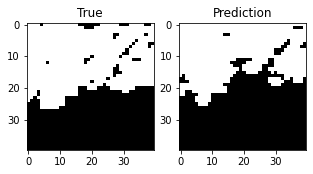

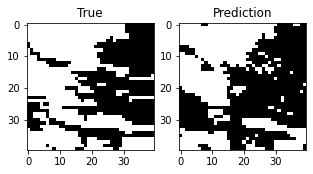

In [42]:
for i in range(2):
    fig = plt.figure(figsize=(5,5))
    rows = 1
    cols = 2
    for j in range(2):
        if j == 0:
            draw=yc_test[i,:,:]
            tit='True'
        else: 
            draw=pred_2d[i,:,:]
            tit='Prediction'
        ax1 = fig.add_subplot(rows, cols, j+1)
        ax1.imshow(draw, cmap='gist_gray', vmin=0, vmax=1)
        ax1.set_title(tit)
        ax1.axis("on")
    plt.show()

## __머신러닝 성능 높이기__

- 가중치 초기화
- Regularization
- drop out
- batch normalization

In [43]:
from torch.utils.data.dataset import random_split

In [44]:
dataset = CustomDataset()
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size,val_size])
print(len(train_dataset), len(val_dataset))

43680 18720


In [47]:
train_loader = DataLoader(dataset=train_dataset, batch_size=1000)
val_loader   = DataLoader(dataset=val_dataset, batch_size=1000)

In [53]:
torch.manual_seed(70)

class gpm_mlp_init(nn.Module):
    """mlp Network"""
    def __init__(self, w_std):
        super(gpm_mlp_init, self).__init__()
        # 층을 구성
        self.layers = nn.Sequential(
            nn.Linear(10, 8),  # in_features, out_features
            nn.Sigmoid(),
            nn.Linear(8, 4),
            nn.Sigmoid(),
            nn.Linear(4, 2),
        )
        
        self.init_weight(w_std)
        
    def init_weight(self, w_std):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if w_std == "xavier":
                    torch.nn.init.xavier_normal_(layer.weight)
                else:
                    std = float(w_std)
                    torch.nn.init.normal_(layer.weight, mean=0, std=std)
        
    def forward(self, x):
        # forward propagation 수행
        o = self.layers(x)
        return o
    
    def predict(self, x):
        o = self.forward(x)
        y = torch.softmax(o, dim=1)
        return y

In [54]:
import time
start = time.time()

model = gpm_mlp_init('1')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
loss_function = nn.CrossEntropyLoss()

nb_epochs = 50
best_loss=999
for epoch in range(nb_epochs + 1):
    model.train()
    for batch_idx, samples in enumerate(train_loader): # enumerate는 인덱스와 데이터를 만드는 함수
       
        #batch 사이즈별 입력과 출력 값
        x_train, y_train = samples
        x_train, y_train = x_train.to(device), y_train.to(device)
        
        # H(x) 계산
        model.to(device)
        prediction = model(x_train)
        
        # cost 계산
        tr_cost = loss_function(prediction, y_train.flatten())

        # cost로 H(x) 계산
        optimizer.zero_grad()
        tr_cost.backward()
        optimizer.step()
    
    if epoch % 5 == 0:
        print('Epoch {:4d}/{} Batch {}/{} Trainin Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(train_loader),  # len(dataloader): 한 에포크당 minibatch개수
        tr_cost.item()
        ))
    
    
    val_cost=0
    with torch.no_grad():
        model.eval()
        # validation을 이용하여 모델 학습 확인
        for batch_idx, samples in enumerate(val_loader): # enumerate는 인덱스와 데이터를 만드는 함수
       
            #batch 사이즈별 입력과 출력 값
            x_train, y_train = samples
            x_train, y_train = x_train.cuda(), y_train.cuda()
        
            # H(x) 계산
            prediction = model(x_train)
        
            # cost 계산
            val_cost += loss_function(prediction, y_train.flatten()).item()
    if epoch % 5 == 0:
        print('Epoch {:4d}/{} Batch {}/{} Validation Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(val_loader),  # len(dataloader): 한 에포크당 minibatch개수
        val_cost/(batch_idx+1)
        ))
    
    if val_cost < best_loss:
        best_loss = val_cost
        torch.save(model.state_dict(), "gpm_mlp_org.pt")

print("time :", time.time() - start)

Epoch    0/50 Batch 44/44 Trainin Cost: 0.789997
Epoch    0/50 Batch 19/19 Validation Cost: 0.799221
Epoch    5/50 Batch 44/44 Trainin Cost: 0.642296
Epoch    5/50 Batch 19/19 Validation Cost: 0.628134
Epoch   10/50 Batch 44/44 Trainin Cost: 0.641611
Epoch   10/50 Batch 19/19 Validation Cost: 0.622540
Epoch   15/50 Batch 44/44 Trainin Cost: 0.641927
Epoch   15/50 Batch 19/19 Validation Cost: 0.622457
Epoch   20/50 Batch 44/44 Trainin Cost: 0.641939
Epoch   20/50 Batch 19/19 Validation Cost: 0.622455
Epoch   25/50 Batch 44/44 Trainin Cost: 0.641941
Epoch   25/50 Batch 19/19 Validation Cost: 0.622455
Epoch   30/50 Batch 44/44 Trainin Cost: 0.641944
Epoch   30/50 Batch 19/19 Validation Cost: 0.622455
Epoch   35/50 Batch 44/44 Trainin Cost: 0.641946
Epoch   35/50 Batch 19/19 Validation Cost: 0.622454
Epoch   40/50 Batch 44/44 Trainin Cost: 0.641949
Epoch   40/50 Batch 19/19 Validation Cost: 0.622454
Epoch   45/50 Batch 44/44 Trainin Cost: 0.641952
Epoch   45/50 Batch 19/19 Validation Cost:

### 가중치 초기화

In [55]:
start = time.time()

model = gpm_mlp_init('xavier')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
loss_function = nn.CrossEntropyLoss()

nb_epochs = 50
best_loss=999
for epoch in range(nb_epochs + 1):
    model.train()
    for batch_idx, samples in enumerate(train_loader): # enumerate는 인덱스와 데이터를 만드는 함수
       
        #batch 사이즈별 입력과 출력 값
        x_train, y_train = samples
        #x_train, y_train = x_train.to(device), y_train.to(device)
        
        # H(x) 계산
        #model.to(device)
        prediction = model(x_train)
        
        # cost 계산
        tr_cost = loss_function(prediction, y_train.flatten())

        # cost로 H(x) 계산
        optimizer.zero_grad()
        tr_cost.backward()
        optimizer.step()
    
    if epoch % 5 == 0:
        print('Epoch {:4d}/{} Batch {}/{} Trainin Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(train_loader),  # len(dataloader): 한 에포크당 minibatch개수
        tr_cost.item()
        ))
    
    
    val_cost=0
    with torch.no_grad():
        model.eval()
        # validation을 이용하여 모델 학습 확인
        for batch_idx, samples in enumerate(val_loader): # enumerate는 인덱스와 데이터를 만드는 함수
       
            #batch 사이즈별 입력과 출력 값
            x_train, y_train = samples
            #x_train, y_train = x_train.cuda(), y_train.cuda()
        
            # H(x) 계산
            prediction = model(x_train)
        
            # cost 계산
            val_cost += loss_function(prediction, y_train.flatten()).item()
    if epoch % 5 == 0:
        print('Epoch {:4d}/{} Batch {}/{} Validation Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(val_loader),  # len(dataloader): 한 에포크당 minibatch개수
        val_cost/(batch_idx+1)
        ))
    
    if val_cost < best_loss:
        best_loss = val_cost
        torch.save(model.state_dict(), "gpm_mlp_init.pt")

print("time :", time.time() - start)

Epoch    0/50 Batch 44/44 Trainin Cost: 0.637224
Epoch    0/50 Batch 19/19 Validation Cost: 0.617671
Epoch    5/50 Batch 44/44 Trainin Cost: 0.612292
Epoch    5/50 Batch 19/19 Validation Cost: 0.594694
Epoch   10/50 Batch 44/44 Trainin Cost: 0.579206
Epoch   10/50 Batch 19/19 Validation Cost: 0.561490
Epoch   15/50 Batch 44/44 Trainin Cost: 0.537816
Epoch   15/50 Batch 19/19 Validation Cost: 0.526033
Epoch   20/50 Batch 44/44 Trainin Cost: 0.507134
Epoch   20/50 Batch 19/19 Validation Cost: 0.502917
Epoch   25/50 Batch 44/44 Trainin Cost: 0.492833
Epoch   25/50 Batch 19/19 Validation Cost: 0.493466
Epoch   30/50 Batch 44/44 Trainin Cost: 0.488735
Epoch   30/50 Batch 19/19 Validation Cost: 0.490743
Epoch   35/50 Batch 44/44 Trainin Cost: 0.488677
Epoch   35/50 Batch 19/19 Validation Cost: 0.490430
Epoch   40/50 Batch 44/44 Trainin Cost: 0.487411
Epoch   40/50 Batch 19/19 Validation Cost: 0.490741
Epoch   45/50 Batch 44/44 Trainin Cost: 0.484399
Epoch   45/50 Batch 19/19 Validation Cost:

### Regularization

In [56]:
start = time.time()

model = gpm_mlp_init('xavier')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1) 
loss_function = nn.CrossEntropyLoss()

nb_epochs = 50
best_loss=999
for epoch in range(nb_epochs + 1):
    model.train()
    for batch_idx, samples in enumerate(train_loader): # enumerate는 인덱스와 데이터를 만드는 함수
       
        #batch 사이즈별 입력과 출력 값
        x_train, y_train = samples
        #x_train, y_train = x_train.to(device), y_train.to(device)
        
        # H(x) 계산
        #model.to(device)
        prediction = model(x_train)
        
        # cost 계산
        tr_cost = loss_function(prediction, y_train.flatten())

        # cost로 H(x) 계산
        optimizer.zero_grad()
        tr_cost.backward()
        optimizer.step()
    
    if epoch % 5 == 0:
        print('Epoch {:4d}/{} Batch {}/{} Trainin Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(train_loader),  # len(dataloader): 한 에포크당 minibatch개수
        tr_cost.item()
        ))
    
    
    val_cost=0
    with torch.no_grad():
        model.eval()
        # validation을 이용하여 모델 학습 확인
        for batch_idx, samples in enumerate(val_loader): # enumerate는 인덱스와 데이터를 만드는 함수
       
            #batch 사이즈별 입력과 출력 값
            x_train, y_train = samples
            #x_train, y_train = x_train.cuda(), y_train.cuda()
        
            # H(x) 계산
            prediction = model(x_train)
        
            # cost 계산
            val_cost += loss_function(prediction, y_train.flatten()).item()
    if epoch % 5 == 0:
        print('Epoch {:4d}/{} Batch {}/{} Validation Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(val_loader),  # len(dataloader): 한 에포크당 minibatch개수
        val_cost/(batch_idx+1)
        ))
    
    if val_cost < best_loss:
        best_loss = val_cost
        torch.save(model.state_dict(), "gpm_mlp_init.pt")

print("time :", time.time() - start)

Epoch    0/50 Batch 44/44 Trainin Cost: 0.626065
Epoch    0/50 Batch 19/19 Validation Cost: 0.610084
Epoch    5/50 Batch 44/44 Trainin Cost: 0.630366
Epoch    5/50 Batch 19/19 Validation Cost: 0.612964
Epoch   10/50 Batch 44/44 Trainin Cost: 0.634679
Epoch   10/50 Batch 19/19 Validation Cost: 0.616728
Epoch   15/50 Batch 44/44 Trainin Cost: 0.637464
Epoch   15/50 Batch 19/19 Validation Cost: 0.619507
Epoch   20/50 Batch 44/44 Trainin Cost: 0.636467
Epoch   20/50 Batch 19/19 Validation Cost: 0.618908
Epoch   25/50 Batch 44/44 Trainin Cost: 0.635102
Epoch   25/50 Batch 19/19 Validation Cost: 0.617212
Epoch   30/50 Batch 44/44 Trainin Cost: 0.635539
Epoch   30/50 Batch 19/19 Validation Cost: 0.617779
Epoch   35/50 Batch 44/44 Trainin Cost: 0.635456
Epoch   35/50 Batch 19/19 Validation Cost: 0.617754
Epoch   40/50 Batch 44/44 Trainin Cost: 0.634626
Epoch   40/50 Batch 19/19 Validation Cost: 0.616979
Epoch   45/50 Batch 44/44 Trainin Cost: 0.634647
Epoch   45/50 Batch 19/19 Validation Cost:

### dropout and batchnorm

In [61]:
torch.manual_seed(70)

class gpm_mlp_dr_bn(nn.Module):
    """mlp Network"""
    def __init__(self, w_std):
        super(gpm_mlp_dr_bn, self).__init__()
        # 층을 구성
        self.layers = nn.Sequential(
            nn.Linear(10, 8),  # in_features, out_features
            nn.BatchNorm1d(8),
            nn.Sigmoid(),
            nn.Dropout(0.3),
            nn.Linear(8, 4),
            nn.BatchNorm1d(4),
            nn.Sigmoid(),
            nn.Linear(4, 2),
        )
        
        self.init_weight(w_std)
        
    def init_weight(self, w_std):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if w_std == "xavier":
                    torch.nn.init.xavier_normal_(layer.weight)
                else:
                    std = float(w_std)
                    torch.nn.init.normal_(layer.weight, mean=0, std=std)
        
    def forward(self, x):
        # forward propagation 수행
        o = self.layers(x)
        return o
    
    def predict(self, x):
        o = self.forward(x)
        y = torch.softmax(o, dim=1)
        return y

In [62]:
start = time.time()

model = gpm_mlp_dr_bn('xavier')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
loss_function = nn.CrossEntropyLoss()

nb_epochs = 50
best_loss=999
for epoch in range(nb_epochs + 1):
    model.train()
    for batch_idx, samples in enumerate(train_loader): # enumerate는 인덱스와 데이터를 만드는 함수
       
        #batch 사이즈별 입력과 출력 값
        x_train, y_train = samples
        #x_train, y_train = x_train.to(device), y_train.to(device)
        
        # H(x) 계산
        #model.to(device)
        prediction = model(x_train)
        
        # cost 계산
        tr_cost = loss_function(prediction, y_train.flatten())

        # cost로 H(x) 계산
        optimizer.zero_grad()
        tr_cost.backward()
        optimizer.step()
    
    if epoch % 5 == 0:
        print('Epoch {:4d}/{} Batch {}/{} Trainin Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(train_loader),  # len(dataloader): 한 에포크당 minibatch개수
        tr_cost.item()
        ))
    
    
    val_cost=0
    with torch.no_grad():
        model.eval()
        # validation을 이용하여 모델 학습 확인
        for batch_idx, samples in enumerate(val_loader): # enumerate는 인덱스와 데이터를 만드는 함수
       
            #batch 사이즈별 입력과 출력 값
            x_train, y_train = samples
            #x_train, y_train = x_train.cuda(), y_train.cuda()
        
            # H(x) 계산
            prediction = model(x_train)
        
            # cost 계산
            val_cost += loss_function(prediction, y_train.flatten()).item()
    if epoch % 5 == 0:
        print('Epoch {:4d}/{} Batch {}/{} Validation Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(val_loader),  # len(dataloader): 한 에포크당 minibatch개수
        val_cost/(batch_idx+1)
        ))
    
    if val_cost < best_loss:
        best_loss = val_cost
        torch.save(model.state_dict(), "gpm_mlp_init.pt")

print("time :", time.time() - start)

Epoch    0/50 Batch 44/44 Trainin Cost: 0.789820
Epoch    0/50 Batch 19/19 Validation Cost: 0.785927
Epoch    5/50 Batch 44/44 Trainin Cost: 0.589422
Epoch    5/50 Batch 19/19 Validation Cost: 0.575930
Epoch   10/50 Batch 44/44 Trainin Cost: 0.538880
Epoch   10/50 Batch 19/19 Validation Cost: 0.505768
Epoch   15/50 Batch 44/44 Trainin Cost: 0.485566
Epoch   15/50 Batch 19/19 Validation Cost: 0.461055
Epoch   20/50 Batch 44/44 Trainin Cost: 0.464900
Epoch   20/50 Batch 19/19 Validation Cost: 0.432280
Epoch   25/50 Batch 44/44 Trainin Cost: 0.450883
Epoch   25/50 Batch 19/19 Validation Cost: 0.418646
Epoch   30/50 Batch 44/44 Trainin Cost: 0.432269
Epoch   30/50 Batch 19/19 Validation Cost: 0.407739
Epoch   35/50 Batch 44/44 Trainin Cost: 0.416297
Epoch   35/50 Batch 19/19 Validation Cost: 0.395764
Epoch   40/50 Batch 44/44 Trainin Cost: 0.400424
Epoch   40/50 Batch 19/19 Validation Cost: 0.384642
Epoch   45/50 Batch 44/44 Trainin Cost: 0.401599
Epoch   45/50 Batch 19/19 Validation Cost: